
# Example — Structural bar network with parallel elements

*(network formulation of a linear elastic structure)*

This example corresponds to **Example 1.4** from:

* Moaveni, S. (2011). *Finite Element Analysis: Theory and Application with ANSYS*, 3rd ed.

<img src="images/barra2.svg" width="400">

The structure consists of **axially loaded bars**, some of which act **in parallel**, sharing the same pair of nodes. This is an important case because it shows how **multiple elements can connect the same nodes**, exactly as in flow networks with parallel pipes.

---

## Physical problem description

We consider a thin structural component of uniform thickness $t$, subdivided into axial bars with different lengths and cross-sectional areas.

Given data:

* Thickness: $t = \frac{1}{16} , \text{in}$

* Young’s modulus: $E = 29 \times 10^6 , \text{lb/in}^2$

* Geometric dimensions:

  * $a = 1 , \text{in}$
  * $b = 4 , \text{in}$
  * $c = 2 , \text{in}$
  * $d = 2 , \text{in}$
  * $e = 1 , \text{in}$

* Applied load: $P = 800 , \text{lb}$

* Prescribed displacement: $u_0 = 0$

---

## Governing equations (structural mechanics)

### Stress, strain, and elasticity

For an axially loaded bar, the **average normal stress** is

$$
\sigma = \frac{F}{A}
$$

The **axial strain** is defined as

$$
\epsilon = \frac{\Delta l}{l}
$$

For a linear elastic material, Hooke’s law applies:

$$
\sigma = E , \epsilon
$$

Combining these relations:

$$
F = \frac{A E}{l} , \Delta l
$$

---

### Element stiffness

We define the **axial stiffness** of element $i$ as

$$
k^i = \frac{A^i E}{l^i}
$$

This leads to the **force–displacement relation**

$$
F^i = k^i , \Delta u^i
$$

This equation has the **same mathematical structure** as a diffusive law:

* Structural: $F = k , \Delta u$
* Hydraulic: $Q = k , \Delta H$
* Thermal (conductive): $q = k , \Delta T$

---

## Element matrix formulation

For a two-node axial bar connecting nodes $k$ and $j$, the local equilibrium equation is

$$
\begin{bmatrix}
f_k^i \\
f_j^i
\end{bmatrix}
= k^i
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\begin{bmatrix}
u_k^i \\
u_j^i
\end{bmatrix}
$$

This matrix is:

* symmetric
* positive definite
* identical in structure to a diffusive element matrix

---

## Network interpretation

We now reinterpret the structural problem as a **diffusive network**:

| Structural quantity | Network quantity |
| ------------------- | ---------------- |
| Displacement $u$    | Nodal state $x$  |
| Force $F$           | Nodal source $b$ |
| Bar                 | Network edge     |
| Stiffness $k$       | Element property |

Parallel bars simply correspond to **parallel edges**, whose stiffnesses are assembled independently.

---

## Network definition

### Create the network

In [1]:
import numpy as np
import netsystems as ns

In [2]:
net = ns.Network()

### Connectivity

In [3]:
connectivity = np.array([
    [0, 1],
    [1, 2],
    [1, 2],   # parallel element
    [2, 3],
])

net.set_connectivity(connectivity)

This network has:

* 4 nodes
* 4 elements
* two elements connecting nodes 1–2


## Structural system as a diffusive system

### System definition

In [4]:
structure = ns.System("structure", system_type="diffusive")

structure.x_name = "nodal_displacement"
structure.b_name = "nodal_force"
structure.element_variable_name = "axial_force"

### Boundary conditions

#### Prescribed displacement (Dirichlet)

$$
u_0 = 0
$$

In [5]:
structure.known_x_nodes = np.array([0])
structure.known_x_values = np.array([0.0])

#### Applied force (Neumann)

$$
F_3 = 800 \, \text{lb}
$$

In [6]:
structure.known_b_nodes = np.array([3])
structure.known_b_values = np.array([800.0])

## Geometry and material properties

### Cross-sectional areas

Using the given geometry:

$$
A_0 = (2d + e) t
$$
$$
A_1 = A_2 = d t
$$
$$
A_3 = A_0
$$

In [7]:
a = 1.0
b = 4.0
c = 2.0
d = 2.0
e = 1.0
t = 1.0 / 16.0
E = 29e6

A0 = (2.0 * d + e) * t
A1 = d * t
A2 = d * t
A3 = A0

A = np.array([A0, A1, A2, A3])

### Element lengths

In [8]:
L = np.array([a, b, b, c])

## Element stiffness (`element_property`)

For each element:

$$
k^i = \frac{A^i E}{L^i}
$$

In [12]:
structure.element_conductance = A * E / L

Here, `element_property` **is the axial stiffness of each bar**, exactly analogous to:

* hydraulic conductivity
* thermal conductance

## Assembly and solution

### Add system to the network

In [13]:
net.add_system(structure)

### Solve the linear system

In [14]:
ns.solve_linear_system(net, "structure")

0

This performs:

1. Element matrix assembly
2. Global stiffness matrix construction
3. Boundary condition enforcement
4. Linear solve


## Extracting results

### Nodal displacements

In [15]:
net.get("nodal_displacement")

array([0.00000000e+00, 8.82758621e-05, 5.29655172e-04, 7.06206897e-04])

### Nodal forces (including reactions)

In [16]:
net.get("nodal_force")

array([-800.,    0.,    0.,  800.])

### Element axial forces

In [17]:
net.get("axial_force")

array([-800., -400., -400., -800.])

Each element force is computed as:

$$
F^i = k^i (u_j - u_k)
$$

## Global stiffness matrix (sparse)

### Obtain sparse matrix

In [18]:
K = ns.get_global_matrix_csr(net, "structure")

print(K.todense())

[[ 9062500. -9062500.        0.        0.]
 [-9062500. 10875000. -1812500.        0.]
 [       0. -1812500.  6343750. -4531250.]
 [       0.        0. -4531250.  4531250.]]


### Visualize sparsity pattern

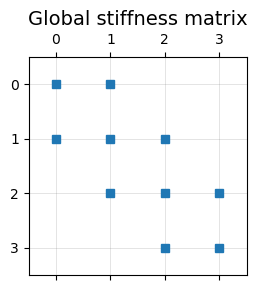

(<Figure size 300x300 with 1 Axes>,
 <Axes: title={'center': 'Global stiffness matrix'}>)

In [19]:
ns.spy_matrix(
    K,
    title="Global stiffness matrix",
    markersize=6,
    figsize=(3, 3)
)